# Import Required Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Dataset and Basic Exploration

In [21]:
file_path = "/content/Local Gasoline Consumption csv.csv"
df = pd.read_csv(file_path)
df.head()

,Unit,Product,BALANCE,Country,Time,Value
0,Thousand Barrels per day (kb/d),Motor and aviation gasoline,Demand,Saudi Arabia,2-Jan,246
1,Thousand Barrels per day (kb/d),Motor and aviation gasoline,Demand,Saudi Arabia,2-Feb,262
2,Thousand Barrels per day (kb/d),Motor and aviation gasoline,Demand,Saudi Arabia,2-Mar,246
3,Thousand Barrels per day (kb/d),Motor and aviation gasoline,Demand,Saudi Arabia,2-Apr,250
4,Thousand Barrels per day (kb/d),Motor and aviation gasoline,Demand,Saudi Arabia,2-May,252


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Unit     276 non-null    object
 1   Product  276 non-null    object
 2   BALANCE  276 non-null    object
 3   Country  276 non-null    object
 4   Time     276 non-null    object
 5   Value    276 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 13.1+ KB


In [23]:
df[['Value']].describe()

,Value
count,276.000000
mean,444.568841
std,109.393164
min,231.000000
25%,350.500000
50%,477.500000
75%,527.500000
max,716.000000


# Feature Extraction – Create Year and Month Columns

In [24]:
df[['Year_short', 'Month_str']] = df['Time'].str.split('-', expand=True)
df['Year'] = 2000 + df['Year_short'].astype(int)
month_map = {
    'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
    'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
}
df['Month'] = df['Month_str'].map(month_map)
df[['Time', 'Year', 'Month', 'Value']].head(10)

,Time,Year,Month,Value
0,2-Jan,2002,1,246
1,2-Feb,2002,2,262
2,2-Mar,2002,3,246
3,2-Apr,2002,4,250
4,2-May,2002,5,252
5,2-Jun,2002,6,259
6,2-Jul,2002,7,258
7,2-Aug,2002,8,255
8,2-Sep,2002,9,267
9,2-Oct,2002,10,250


#Yearly Consumption

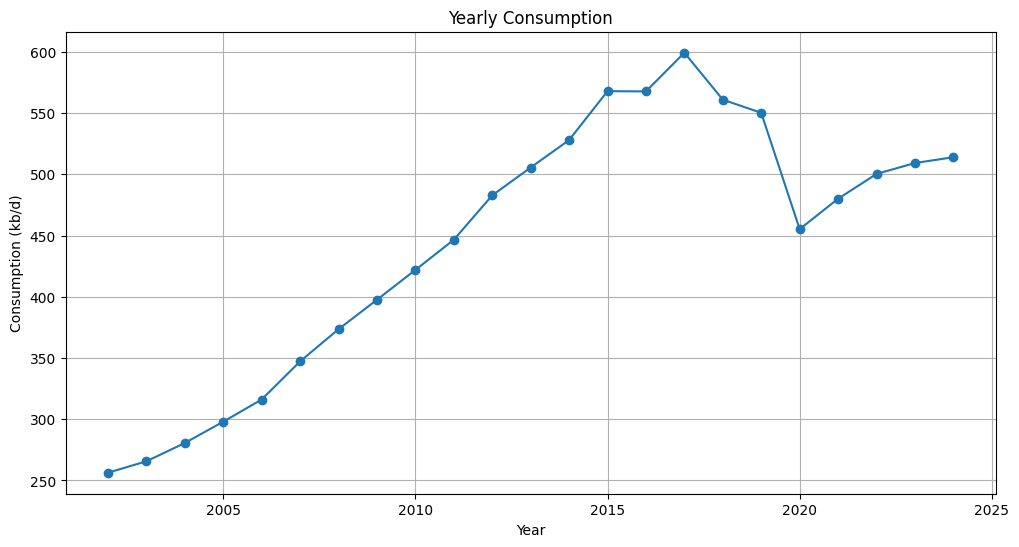

In [25]:
yearly = df.groupby('Year')['Value'].mean()
plt.figure(figsize=(12,6))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title('Yearly Consumption')
plt.xlabel('Year')
plt.ylabel('Consumption (kb/d)')
plt.grid(True)
plt.show()

#Monthly Average Consumption

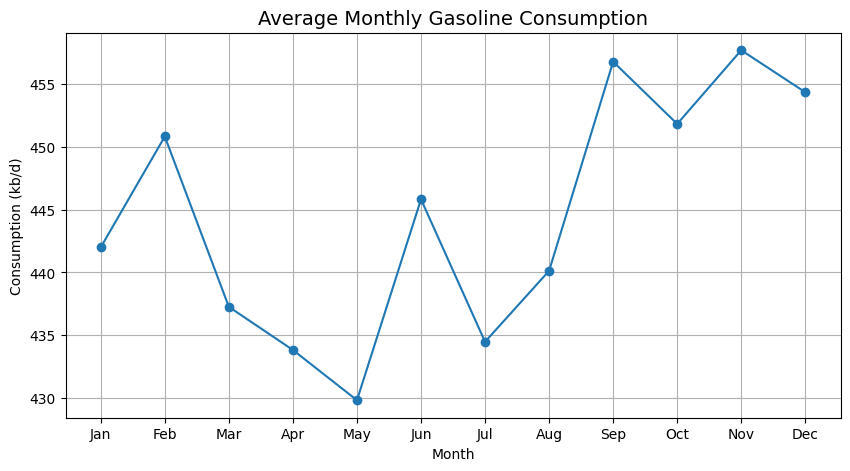

In [26]:

monthly = df.groupby('Month')['Value'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly.index, monthly.values, marker='o')

plt.title('Average Monthly Gasoline Consumption', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Consumption (kb/d)')

plt.xticks(
    ticks=range(1,13),
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)
plt.grid(True)
plt.show()

# Boxplot – Detect Seasonal Variations & Outliers

<Figure size 1000x500 with 0 Axes>

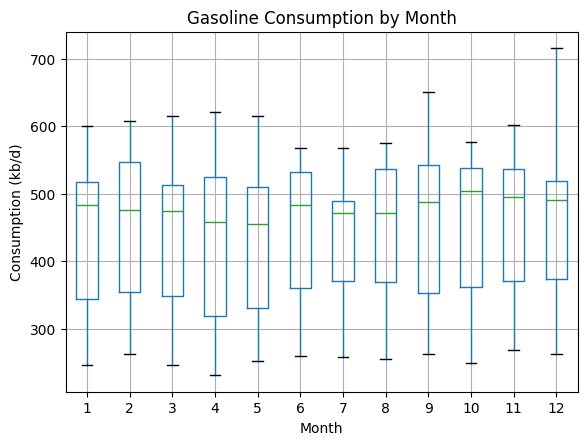

In [27]:
plt.figure(figsize=(10,5))
df.boxplot(column='Value', by='Month')
plt.title('Gasoline Consumption by Month')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Consumption (kb/d)')
plt.grid(True)
plt.show()

# Distribution Analysis – Histogram

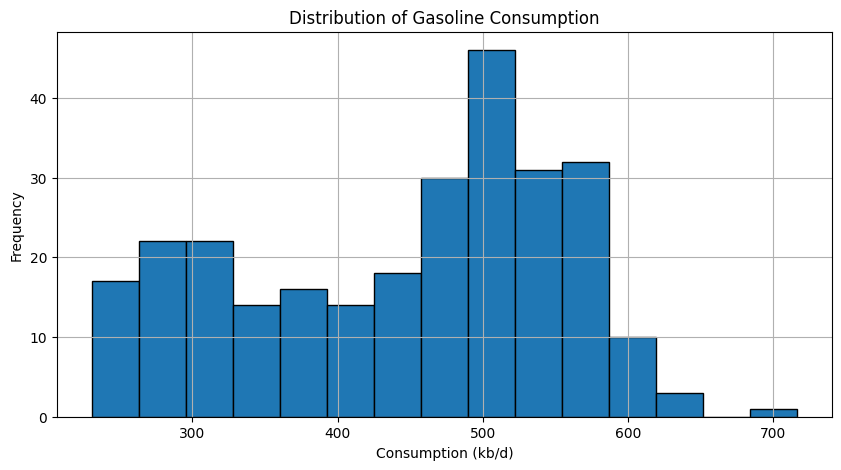

In [28]:
plt.figure(figsize=(10,5))
plt.hist(df['Value'], bins=15, edgecolor='black')
plt.title('Distribution of Gasoline Consumption')
plt.xlabel('Consumption (kb/d)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Prepare Time Series Data for Modeling

In [29]:
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))

df[['Time', 'Year', 'Month', 'Date', 'Value']].head(5)

df_ts = df[['Date', 'Value']]
df_ts = df_ts.set_index('Date')
df_ts

,Value
Date,
2002-01-01,246
2002-02-01,262
2002-03-01,246
2002-04-01,250
2002-05-01,252
...,...
2024-08-01,558
2024-09-01,529
2024-10-01,546


# SARIMA Model – Training & Forecasting

In [30]:
#ADF Test : for check if time series is stationary or non-stationary
result = adfuller(df_ts['Value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# note : if p-value < 0.05 Stationary else Non-stationary

ADF Statistic: -1.7768172334790246
p-value: 0.39203050603656986


# SARIMA Model – Training & Forecasting

Forecasting = Predicting future values based on historical patterns

In [31]:

df_ts = df[['Date', 'Value']].set_index('Date').asfreq('MS')

train = df_ts.iloc[:-12]# من 2002 إلى نهاية 2023
test = df_ts.iloc[-12:]# سنة 2024 فقط

model = SARIMAX(train['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)

forecast = results.get_forecast(steps=len(test))
pred = forecast.predicted_mean


#Model Evaluation – Calculate MAE and RMSE

In [32]:
mae = mean_absolute_error(test['Value'], pred)
rmse = np.sqrt(mean_squared_error(test['Value'], pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 14.989105172904743
RMSE: 19.514047679774198


# Plot Train vs Test vs Forecast

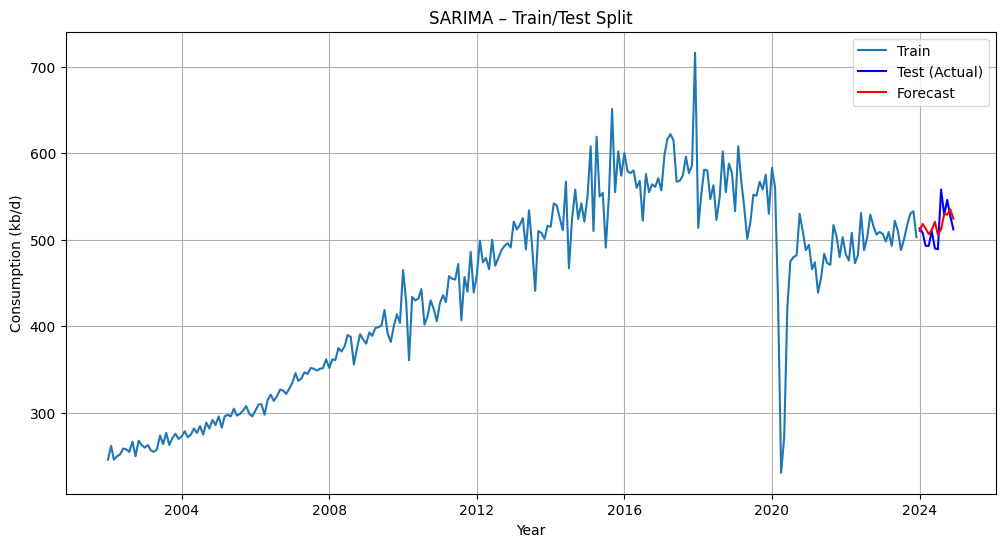

In [33]:

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Value'], label='Train')
plt.plot(test.index, test['Value'], label='Test (Actual)', color='blue')
plt.plot(pred.index, pred, label='Forecast', color='red')
plt.title('SARIMA – Train/Test Split')
plt.xlabel('Year')
plt.ylabel('Consumption (kb/d)')
plt.legend()
plt.grid(True)
plt.show()

#Final SARIMA model on full data (for future forecasting)

In [34]:
df_ts = df[['Date', 'Value']].set_index('Date').asfreq('MS')

model_full = SARIMAX(df_ts['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_full = model_full.fit(disp=False)


#Forecast future gasoline consumption (next 3 years)


In [35]:

#عدد سنوات التبؤ 3 سنوات
future_steps = 36

future_forecast = results_full.get_forecast(steps=future_steps)
future_pred = future_forecast.predicted_mean         # القيم المتنبأ بها
future_conf = future_forecast.conf_int()             # نطاق الثقة (Lower & Upper)

forecast_df = pd.DataFrame({
    'Date': future_pred.index,
    'Forecast_Value': future_pred.values,
    'Lower_CI': future_conf.iloc[:, 0].values,
    'Upper_CI': future_conf.iloc[:, 1].values
})



In [36]:
# اول 5 شهور في التنبؤ
print("First 5 forecasted months:")
print(forecast_df.head())

print("\nLast 5 forecasted months:")
print(forecast_df.tail())

First 5 forecasted months:
        Date  Forecast_Value    Lower_CI    Upper_CI
0 2025-01-01      519.801787  458.044351  581.559223
1 2025-02-01      526.829031  457.112352  596.545710
2 2025-03-01      513.651102  440.825529  586.476676
3 2025-04-01      511.481003  436.764642  586.197363
4 2025-05-01      513.851796  437.638959  590.064634

Last 5 forecasted months:
         Date  Forecast_Value    Lower_CI    Upper_CI
31 2027-08-01      546.228438  418.654716  673.802159
32 2027-09-01      561.077127  431.899138  690.255116
33 2027-10-01      556.769661  426.005575  687.533746
34 2027-11-01      561.780490  429.445100  694.115879
35 2027-12-01      557.872743  423.975364  691.770121


#Plot historical data + future forecast

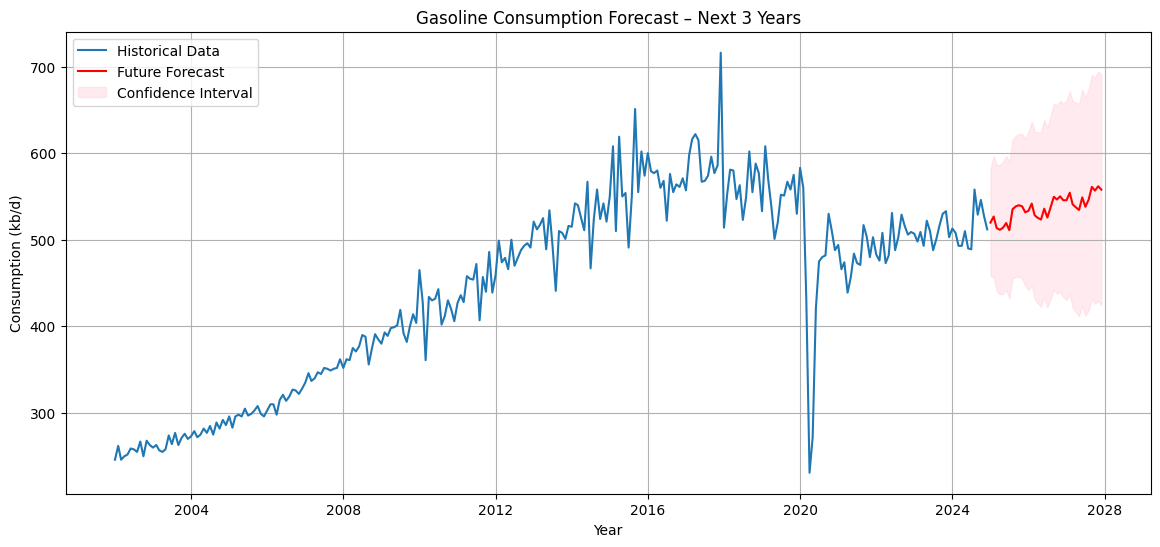

In [37]:

plt.figure(figsize=(14,6))

# البيانات التاريخية
plt.plot(df_ts.index, df_ts['Value'], label='Historical Data')

# التنبؤات المستقبلية
plt.plot(forecast_df['Date'], forecast_df['Forecast_Value'],
         label='Future Forecast', color='red')

#(Confidence Interval)
plt.fill_between(
    forecast_df['Date'],
    forecast_df['Lower_CI'],
    forecast_df['Upper_CI'],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title('Gasoline Consumption Forecast – Next 3 Years')
plt.xlabel('Year')
plt.ylabel('Consumption (kb/d)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# Filter فقط سنة 2026
forecast_2026 = forecast_df[forecast_df['Date'].dt.year == 2026]
forecast_2026


,Date,Forecast_Value,Lower_CI,Upper_CI
12,2026-01-01,533.469723,442.084031,624.855414
13,2026-02-01,541.781496,447.193645,636.369347
14,2026-03-01,528.311090,431.472574,625.149605
15,2026-04-01,525.223220,426.469876,623.976563
16,2026-05-01,523.371883,422.842638,623.901129
17,2026-06-01,535.921109,433.684793,638.157424
18,2026-07-01,525.678134,421.776989,629.579280
19,2026-08-01,537.301402,431.766860,642.835944
20,2026-09-01,549.612587,442.471031,656.754143
21,2026-10-01,546.538642,437.813214,655.264070
